Beata Sirowy
# DAG structure and operators in Apache Airflow
Based on Apache Airflow documentation(airflow.apache.org), the IBM Data Engineering Professional Certificate, _ETL and Data Pipelines with Shell, Airflow and Kafka_ <br> Images' copyright: IBM Skills Network and airflow.apache.org

Airflow is a platform that lets you build and run workflows (for a more detailed information see: [05_Apache_Airflow.ipynb](https://github.com/bea-sirowy/data-science-tutorials/blob/2a35b71ef80d1384af5261e60b09d162badcdb02/05_Apache_Airflow.ipynb)). <br> 

An Airflow workflow is represented as a DAG (__a Directed Acyclic Graph__), and contains individual pieces of work called Tasks, arranged with dependencies and data flows taken into account.

A directed acyclic graph (DAG) is a Python program where you define the tasks and the pipeline with the order in which the tasks will be executed.

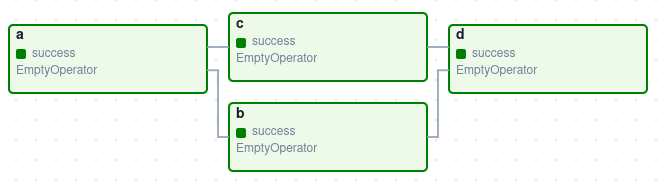

- a DAG is the core concept of Airflow, collecting Tasks together, organized with dependencies and relationships to say how they should run.
- the DAG itself doesn’t care about what is happening inside the tasks; it is merely concerned with how to execute them - the order to run them in, how many times to retry them, if they have timeouts, and so on.

A DAG consists of these logical blocks.

    Imports
    DAG Arguments
    DAG Definition
    Task Definitions
    Task Pipeline

## Declaring a DAG

Airflow loads DAGs from Python source files, which it looks for inside its configured DAG_FOLDER. It will take each file, execute it, and then load any DAG objects from that file.

The following Python code snippets present three ways to declare a DAG 
- you can use with statement (context manager), which will add anything inside it to the DAG implicitly:

In [ ]:
 import datetime

 from airflow import DAG
 from airflow.operators.empty import EmptyOperator

 with DAG(
     dag_id="my_dag_name",
     start_date=datetime.datetime(2021, 1, 1),
     schedule="@daily",
 ):
     EmptyOperator(task_id="task")

- you can use a standard constructor, passing the DAG into any operators you use:

In [ ]:
import datetime

 from airflow import DAG
 from airflow.operators.empty import EmptyOperator

 my_dag = DAG(
     dag_id="my_dag_name",
     start_date=datetime.datetime(2021, 1, 1),
     schedule="@daily",
 )
 EmptyOperator(task_id="task", dag=my_dag)


- you can use the @dag decorator to turn a function into a DAG generator:

In [ ]:
import datetime

from airflow.decorators import dag
from airflow.operators.empty import EmptyOperator


@dag(start_date=datetime.datetime(2021, 1, 1), schedule="@daily")
def generate_dag():
    EmptyOperator(task_id="task")


generate_dag()


DAGs will run in one of two ways:

- When they are triggered either manually or via the API

- On a defined schedule, which is defined as part of the DAG



### Tasks and task dependencies 
A Task is the basic unit of execution in Airflow. 

DAGs are nothing without Tasks to run, and those will usually come in the form of either Operators, Sensors or TaskFlow.


-  __Operators__, predefined task templates that you can string together quickly to build most parts of your DAGs.

- __Sensors__, a special subclass of Operators which are entirely about waiting for an external event to happen.

-  A __TaskFlow__-decorated @task, which is a custom Python function packaged up as a Task.


A Task/Operator does not usually live alone - it has dependencies on other tasks (those upstream of it), and other tasks depend on it (those downstream of it). Declaring these dependencies between tasks is what makes up the DAG structure (the edges of the directed acyclic graph).

There are two main ways to declare individual task dependencies. The recommended one is to use the >> and << operators:

In [ ]:
first_task >> [second_task, third_task]
third_task << fourth_task

You can also use the more explicit set_upstream and set_downstream methods:

In [ ]:
first_task.set_downstream([second_task, third_task])
third_task.set_upstream(fourth_task)

### Airflow operators for task definition


Airflow offers a wide range of operators, including many that are built into the core or are provided by pre-installed providers. Some popular core operators include:

- BashOperator - executes a bash command

- PythonOperator - calls an arbitrary Python function

- EmailOperator - sends an email

The other core operators available include:

- BaseBranchOperator - A base class for creating operators with branching functionality

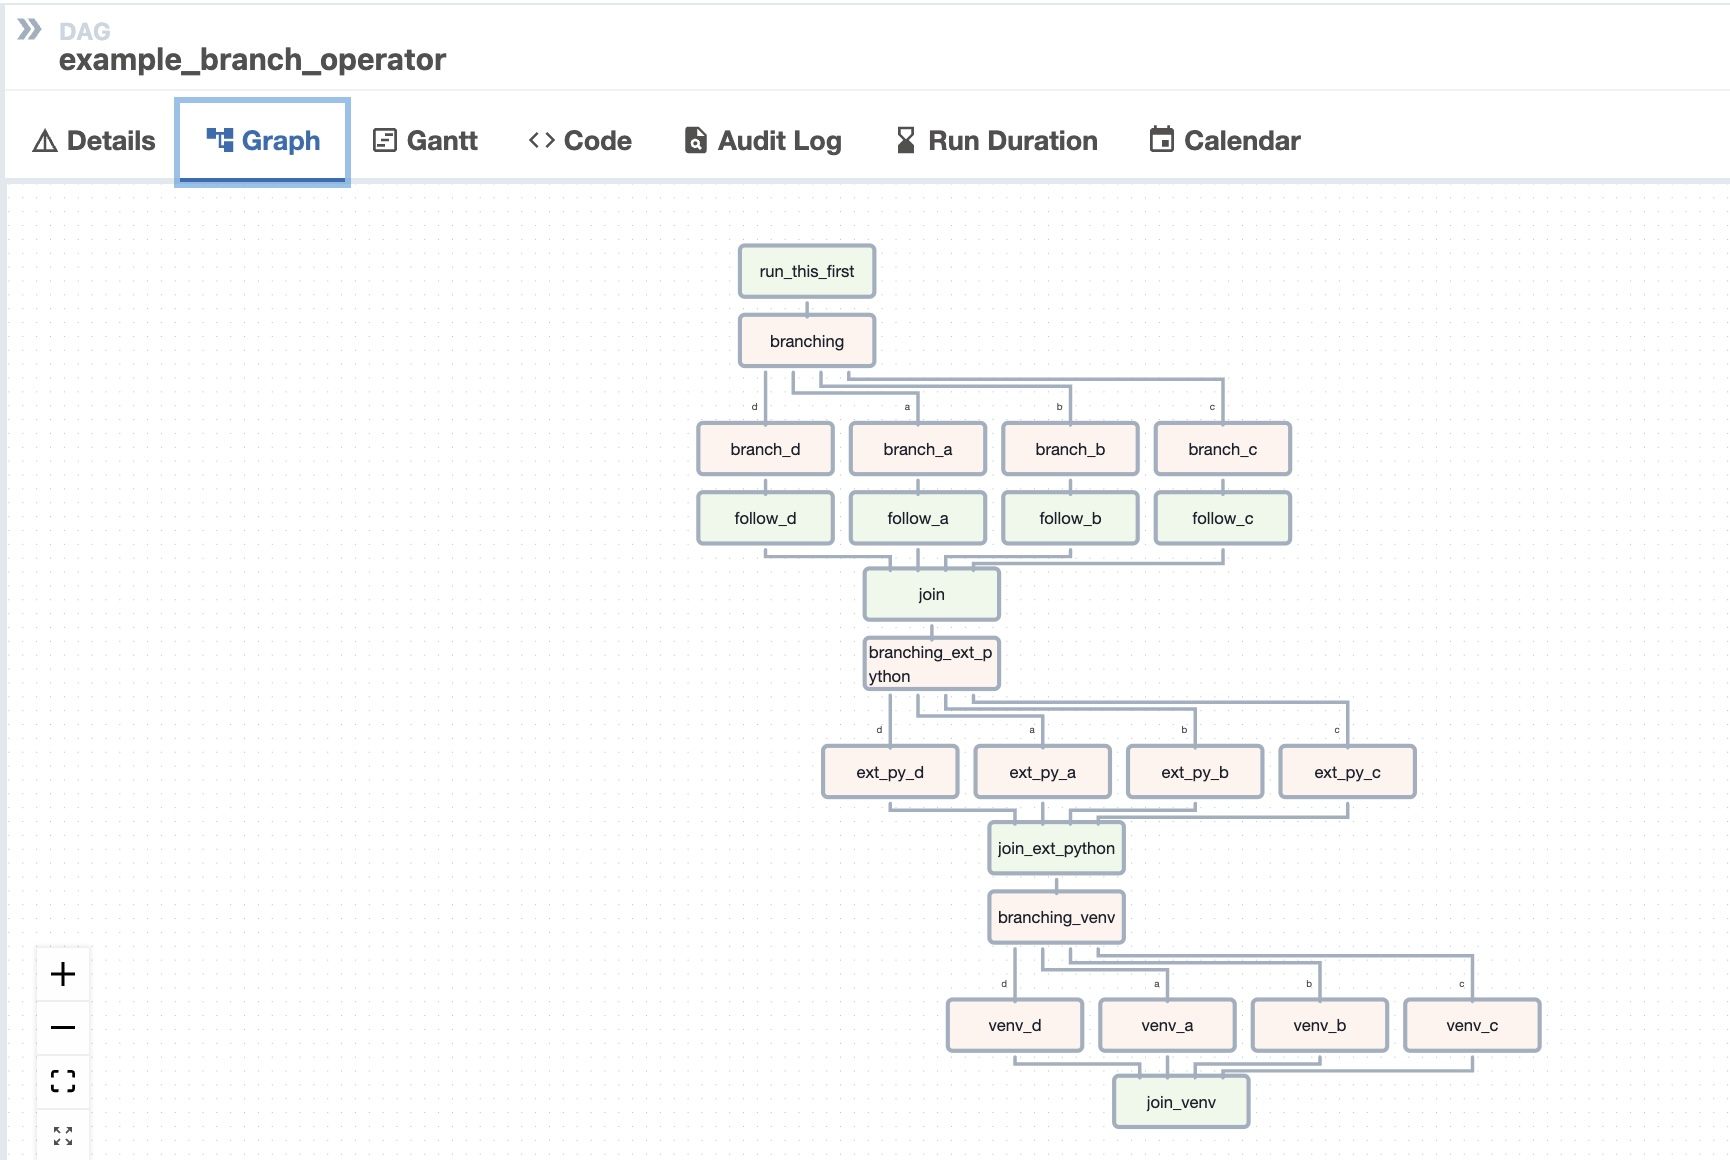

- BranchDateTimeOperator
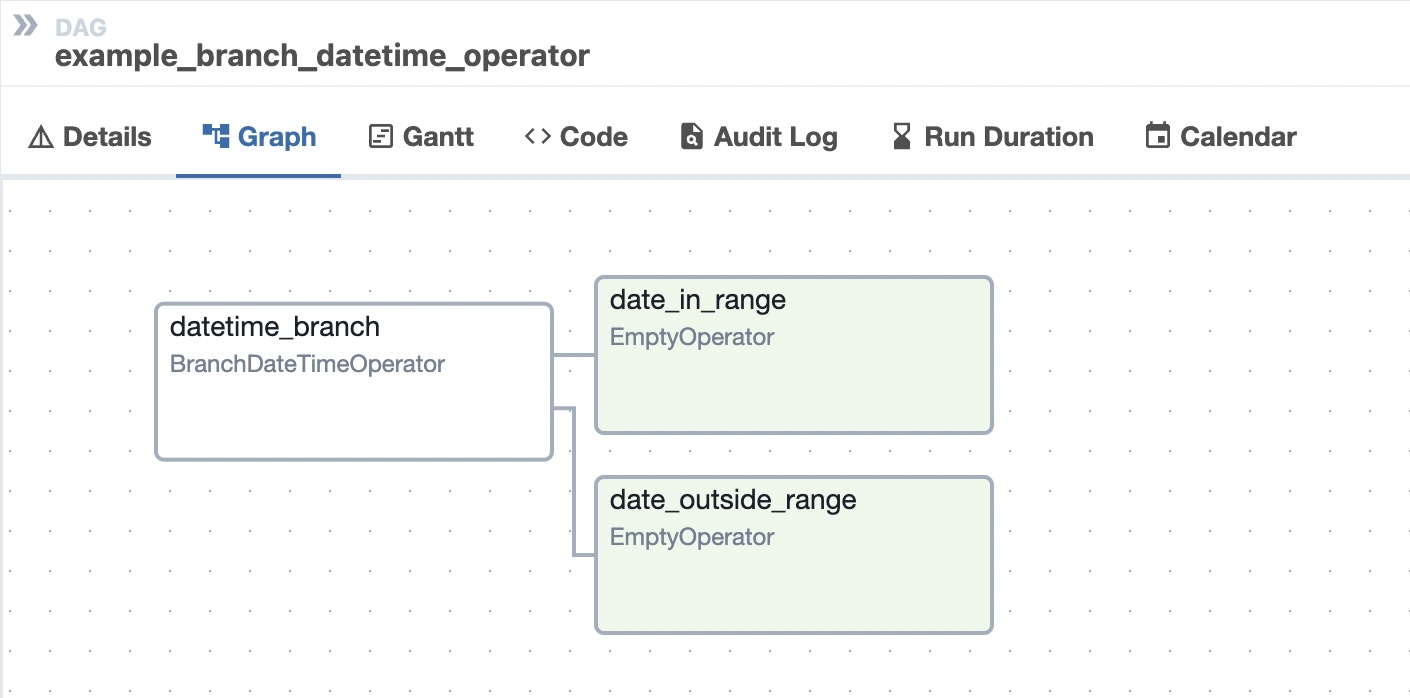

- mptyOperator - Operator that does nothing

- GenericTransfer - Moves data from on database connection to another.

- LatestOnlyOperator - Skip tasks that are not running during the most recent schedule interval.

- TriggerDagRunOperator - Triggers a DAG run for a specified dag_id.

Besides these, there are also many __community provided operators__. Some of the popular ones are:

- HttpOperator

- MySqlOperator

- PostgresOperator

- OracleOperator

- JdbcOperator

- DockerOperator

- HiveOperator

- S3FileTransformOperator

- PrestoToMySqlOperator

- SlackAPIOperator


### DAG assignment

Every single Operator/Task must be assigned to a DAG in order to run. Airflow has several ways of calculating the DAG without you passing it explicitly:

- If you declare your Operator inside a with DAG block

- If you declare your Operator inside a @dag decorator

- If you put your Operator upstream or downstream of an Operator that has a DAG

Otherwise, you must pass it into each Operator with dag=.

### Default arguments
Often, many Operators inside a DAG need the same set of default arguments (such as their retries). Rather than having to specify this individually for every Operator, you can instead pass default_args to the DAG when you create it, and it will auto-apply them to any operator tied to it:

In [ ]:
import pendulum

with DAG(
    dag_id="my_dag",
    start_date=pendulum.datetime(2016, 1, 1),
    schedule="@daily",
    default_args={"retries": 2},
):
    op = BashOperator(task_id="hello_world", bash_command="Hello World!")
    print(op.retries)  # 2

### Task instances
Each time a DAG runs, the tasks under it are instantiated into Task Instances.

An instance of a Task is a specific run of that task for a given DAG (and thus for a given data interval). They are also the representation of a Task that has state, representing what stage of the lifecycle it is in.

The possible states for a Task Instance are:


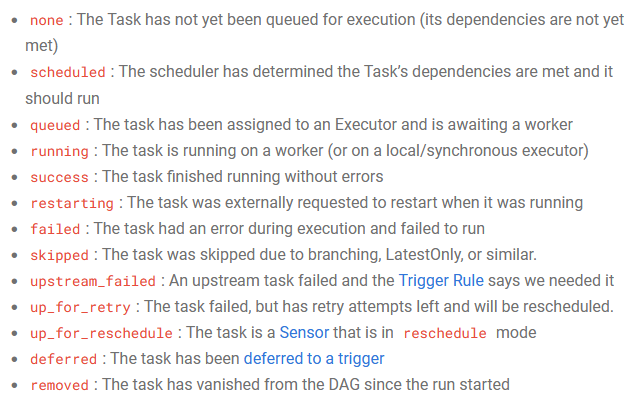

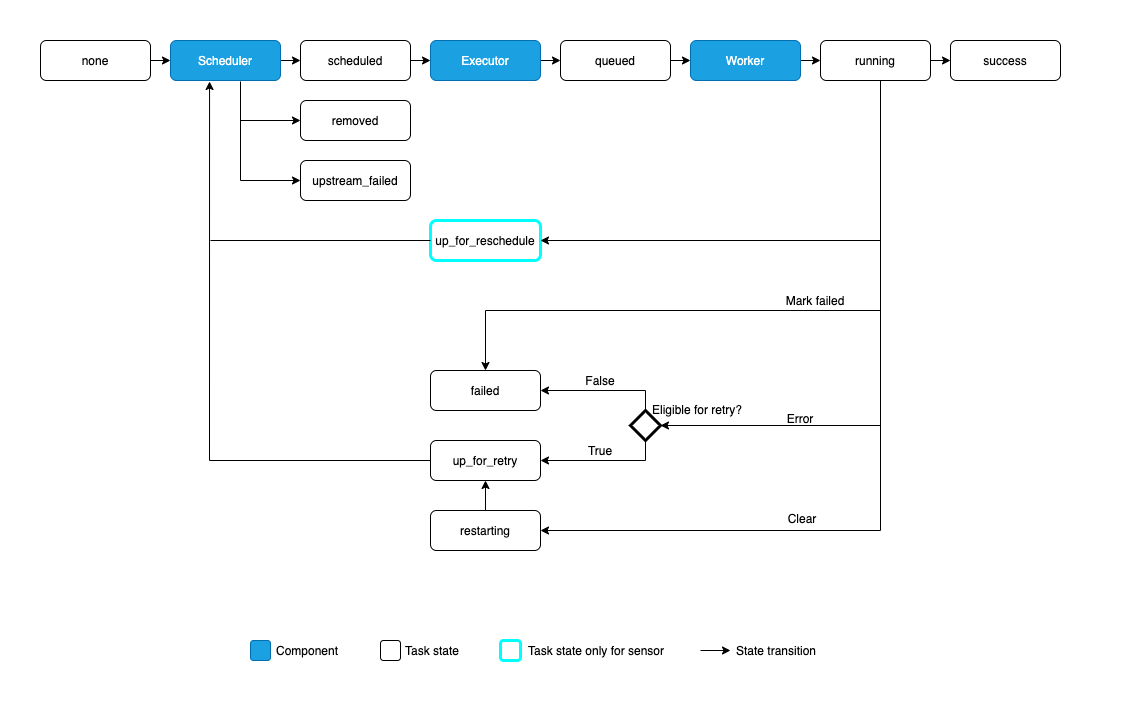

Ideally, a task should flow from none, to scheduled, to queued, to running, and finally to success.